In [1]:
import os
os.environ["CALITP_BQ_MAX_BYTES"] = str(1_000_000_000_000) ## 1TB?

import _utils # amanda's collected utils
from calitp.sql import to_snakecase

import pandas as pd
import geopandas as gpd
from siuba import *

import shared_utils

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


# Safety Metrics Development

In [4]:
# read in collated/cleaned SWITRS data from Safety Office
switrs = (to_snakecase(
    pd.read_excel(f"{_utils.GCS_FILE_PATH}SWITRS_Full_CACV_20220127.xlsx"))
         ) >> filter(_.sc_accident_year >= 2015)


switrs.head(10)

,sc_case_id,sc_accident_year,proc_date,juris,collision_date,collision_time,officer_id,reporting_district,day_of_week,chp_shift,...,occupantprotectionv,pedestrianv,workzonesv,youngdriversv,id__tb,case_id__tb,point_x__tb,point_y__tb,near_dist_mile,near_tribe
54385,6292116,2015,20150424,3300,20150102,1844,3775,6.02E+05,5,5,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54386,6292117,2015,20160108,9390,20150104,1817,20587,NaN,7,2,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54387,6292117,2015,20160108,9390,20150104,1817,20587,NaN,7,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54388,6292118,2015,20150429,9390,20150105,1650,20557,NaN,1,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54389,6292119,2015,20150424,103,20150113,1843,8,30,2,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54390,6292120,2015,20150429,9525,20150115,1350,16679,NaN,4,1,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54391,6292121,2015,20150429,9220,20150118,2030,13676,NaN,7,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54393,6292126,2015,20150513,1900,20150218,1257,436136,1328,3,5,...,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN
54394,6292127,2015,20170421,3019,20150218,1223,2888,SE,3,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54395,6292128,2015,20150519,9770,20150219,1700,17732,NaN,4,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
switrs.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90744 entries, 54385 to 159095
Data columns (total 168 columns):
 #    Column                       Non-Null Count  Dtype  
---   ------                       --------------  -----  
 0    sc_case_id                   90744 non-null  int64  
 1    sc_accident_year             90744 non-null  int64  
 2    proc_date                    90744 non-null  int64  
 3    juris                        90744 non-null  object 
 4    collision_date               90744 non-null  int64  
 5    collision_time               90744 non-null  int64  
 6    officer_id                   90635 non-null  object 
 7    reporting_district           30706 non-null  object 
 8    day_of_week                  90744 non-null  int64  
 9    chp_shift                    90744 non-null  int64  
 10   population                   90744 non-null  int64  
 11   cnty_city_loc                90744 non-null  int64  
 12   special_cond                 90744 non-null  int64  


In [6]:
# appears to be all tables (crash, pary, victim) merged together; dedup on sc_case_id
# need to test this assumption at some point
switrs = switrs.drop_duplicates(subset = ['sc_case_id'])

Test Metrics:
* n fatalities within 100ft buffer of project area over 5 year lookback period
    * test different temporal study periods; rural may need more time
    * test different buffers; different project types may need different sizes
* n fatalities+severely injured (KSIs) w/in buffer area
* n ped/bike crashes w/in buffer area
* % ped/bike crashes out of all crashes w/in buffer area

In [25]:
# make geodataframe w/ relevant columns 
switrs_gdf = gpd.GeoDataFrame(
    switrs, geometry=gpd.points_from_xy(switrs.point_x, switrs.point_y))

In [26]:
switrs_gdf.info(verbose=True, show_counts=True)

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 79230 entries, 54385 to 159093
Data columns (total 169 columns):
 #    Column                       Non-Null Count  Dtype   
---   ------                       --------------  -----   
 0    sc_case_id                   79230 non-null  int64   
 1    sc_accident_year             79230 non-null  int64   
 2    proc_date                    79230 non-null  int64   
 3    juris                        79230 non-null  object  
 4    collision_date               79230 non-null  int64   
 5    collision_time               79230 non-null  int64   
 6    officer_id                   79141 non-null  object  
 7    reporting_district           27828 non-null  object  
 8    day_of_week                  79230 non-null  int64   
 9    chp_shift                    79230 non-null  int64   
 10   population                   79230 non-null  int64   
 11   cnty_city_loc                79230 non-null  int64   
 12   special_cond                 79

In [27]:
# filter out, investigate crashes with missing geometry
missing_geo = (switrs_gdf
               >> filter(_.point_x.isna())
              )

len(missing_geo)

29924

In [28]:
missing_geo.head(5)

,sc_case_id,sc_accident_year,proc_date,juris,collision_date,collision_time,officer_id,reporting_district,day_of_week,chp_shift,...,pedestrianv,workzonesv,youngdriversv,id__tb,case_id__tb,point_x__tb,point_y__tb,near_dist_mile,near_tribe,geometry
54385,6292116,2015,20150424,3300,20150102,1844,3775,6.02E+05,5,5,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT EMPTY
54389,6292119,2015,20150424,103,20150113,1843,8,30,2,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT EMPTY
54393,6292126,2015,20150513,1900,20150218,1257,436136,1328,3,5,...,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,POINT EMPTY
54394,6292127,2015,20170421,3019,20150218,1223,2888,SE,3,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT EMPTY
54396,6292131,2015,20170421,5407,20150219,400,M222,480,4,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT EMPTY


In [29]:
missing_geo2 = switrs_gdf[switrs_gdf.geometry.is_empty]

len(missing_geo2)

29924

In [30]:
switrs_gdf_geo = (switrs_gdf
                  >> filter(-_.geometry.is_empty)
                 )

<AxesSubplot:>

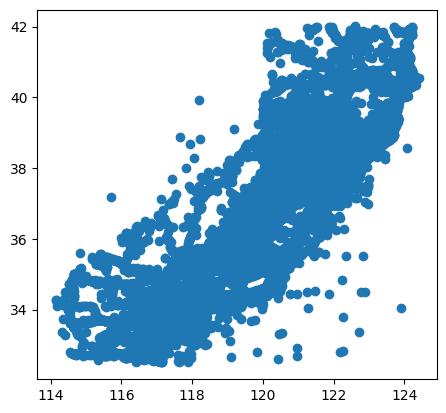

In [32]:
switrs_gdf_geo.plot()